# Import packages

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pathlib
import io
from datetime import datetime
import json
import xml.etree.ElementTree as ET
import os
import shutil
import cv2
import time
import random
from PIL import Image
from sklearn.metrics import average_precision_score
import albumentations as A
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal

# Plot setup
import matplotlib as mpl
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')
from IPython.display import display, Markdown

# To avoid non-essential warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

# Dataset Download

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d huanghanchina/pascal-voc-2012

In [ ]:
!unzip "/content/pascal-voc-2012.zip" -d "/content/dataset/"

In [3]:
train_images_dir='/content/dataset/VOC2012/JPEGImages/'
train_maps_dir='/content/dataset/VOC2012/Annotations/'

# List all files in the directory
file_list = os.listdir(train_images_dir)

# Filter the list to include only image files (.jpg)
image_files = [file for file in file_list if file.lower().endswith(('.jpg'))]

# number of images to select for validation and test sets (10% each)
num_images = len(image_files)
num_val_images = int(0.10 * num_images)
num_test_images = int(0.10 * num_images)

# Print the number of images
print(f"Number of images: {len(image_files)}")

In [4]:
# Define the seed for reproducibility
random.seed(42)

# Randomly select images for validation set
val_list = random.sample(image_files, num_val_images)

# Remove selected images from the image_files list
for image_file in val_list:
    image_files.remove(image_file)

# Randomly select images for test set
test_list = random.sample(image_files, num_test_images)

# Remove selected images from the image_files list
for image_file in test_list:
    image_files.remove(image_file)

# Print the number of images in each set
print(f"Number of images in training list: {len(image_files)}")
print(f"Number of images in validation list: {len(val_list)}")
print(f"Number of images in test list: {len(test_list)}")

In [ ]:
val_images_dir='/content/dataset/VOC2012/ValJPEGImages/'
val_maps_dir='/content/dataset/VOC2012/ValAnnotations/'

test_images_dir='/content/dataset/VOC2012/TestJPEGImages/'
test_maps_dir='/content/dataset/VOC2012/TestAnnotations/'

In [ ]:
!mkdir /content/dataset/VOC2012/ValJPEGImages/
!mkdir /content/dataset/VOC2012/ValAnnotations/
!mkdir /content/dataset/VOC2012/TestJPEGImages/
!mkdir /content/dataset/VOC2012/TestAnnotations/

In [ ]:
for name in val_list:
  shutil.move(train_maps_dir+name[:-3]+"xml", val_maps_dir+name[:-3]+"xml")

for name in val_list:
  shutil.move(train_images_dir+name, val_images_dir+name)

In [ ]:
for name in test_list:
  shutil.move(train_maps_dir+name[:-3]+"xml", test_maps_dir+name[:-3]+"xml")

for name in test_list:
  shutil.move(train_images_dir+name, test_images_dir+name)

In [5]:
file_list = os.listdir(train_images_dir)
image_file = [file for file in file_list if file.lower().endswith(('.jpg'))]
print(f"Number of images in training set: {len(image_file)}")

file_list = os.listdir(val_images_dir)
image_file = [file for file in file_list if file.lower().endswith(('.jpg'))]
print(f"Number of images in validation set: {len(image_file)}")

file_list = os.listdir(test_images_dir)
image_file = [file for file in file_list if file.lower().endswith(('.jpg'))]
print(f"Number of images in test set: {len(image_file)}")

# Data Preparation

In [ ]:
classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
         'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

B=2
N_CLASSES=len(classes)
H,W =224,224
SPLIT_SIZE=H//32
N_EPOCHS=150
BATCH_SIZE=32

In [ ]:
def preprocess_xml(filename):
  tree = ET.parse(filename)
  root = tree.getroot()
  loc = root.find('size')
  h = float(loc.find('height').text)
  w = float(loc.find('width').text)
  a=[]
  for i in root.findall('object'):
    for j in i.iter('bndbox'):
      top_l_x = (float(j.find('xmin').text))
      top_l_y = (float(j.find('ymin').text))
      bot_r_x = (float(j.find('xmax').text))
      bot_r_y = (float(j.find('ymax').text))
      break
    classification = i.find('name').text
    classification_dict={classes[i]:i for i in range(len(classes))}
    a_ch = [
        (top_l_x + bot_r_x)/(2*w),(top_l_y + bot_r_y)/(2*h),(bot_r_x-top_l_x)/w,
        (bot_r_y-top_l_y)/h, classification_dict[classification]]
    a.append(a_ch)
  return tf.convert_to_tensor(a)

In [ ]:
def generate_output(bounding_boxes):
  output_label=np.zeros((SPLIT_SIZE,SPLIT_SIZE,N_CLASSES+5))
  for b in range(len(bounding_boxes)):
    grid_x=bounding_boxes[...,b,0]*SPLIT_SIZE
    grid_y=bounding_boxes[...,b,1]*SPLIT_SIZE
    i=int(grid_x)
    j=int(grid_y)

    output_label[i,j,0:5]=[1.,grid_x%1,grid_y%1,bounding_boxes[...,b,2],bounding_boxes[...,b,3]]
    output_label[i,j,5+int(bounding_boxes[...,b,4])]=1.

  return tf.convert_to_tensor(output_label,tf.float32)

In [ ]:
im_paths=[]
xml_paths=[]

val_im_paths=[]
val_xml_paths=[]


for i in os.listdir(train_maps_dir):

  im_paths.append(train_images_dir+i[:-3]+'jpg')
  xml_paths.append(train_maps_dir+i)

for i in os.listdir(val_maps_dir):

  val_im_paths.append(val_images_dir+i[:-3]+'jpg')
  val_xml_paths.append(val_maps_dir+i)

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((im_paths,xml_paths))
val_dataset=tf.data.Dataset.from_tensor_slices((val_im_paths,val_xml_paths))

In [ ]:
def get_imbboxes(im_path,xml_path):
  img=tf.io.decode_jpeg(tf.io.read_file(im_path))
  img=tf.cast(tf.image.resize(img, [H,W]),dtype=tf.float32)

  bboxes=tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout=tf.float32)
  return img,bboxes

In [ ]:
train_dataset=train_dataset.map(get_imbboxes)
val_dataset=val_dataset.map(get_imbboxes)

In [ ]:
def display_image(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    if image is not None:
        # Convert BGR to RGB (OpenCV loads images in BGR format)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image using matplotlib
        plt.imshow(image_rgb)
        plt.axis('off')  # Turn off axis labels and ticks
        plt.show()
    else:
        print(f"Failed to load the image at path: {image_path}")

In [6]:
for i,j in train_dataset.skip(0):
  # print(i.shape,j)
  break

cv2.imwrite('out_1.jpg',np.array(i))

# display_image('out_1.jpg')

In [ ]:
transforms = A.Compose([
    A.Resize(H,W),
    A.RandomCrop(
         width=np.random.randint(int(0.9*W),W),
         height=np.random.randint(int(0.9*H),H), p=0.5),
    A.RandomScale(scale_limit=0.1, interpolation=cv2.INTER_LANCZOS4,p=0.5),
    A.HorizontalFlip(p=0.5,),
    A.Resize(H,W),

], bbox_params=A.BboxParams(format='yolo', ))

In [ ]:
def aug_albument(image,bboxes):
  augmented=transforms(image=image,bboxes=bboxes)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["bboxes"],dtype=tf.float32)]

In [ ]:
def process_data(image,bboxes):
    aug= tf.numpy_function(func=aug_albument, inp=[image,bboxes], Tout=(tf.float32,tf.float32))
    return aug[0],aug[1]

In [ ]:
train_dataset=train_dataset.map(process_data)

In [7]:
for i,j in train_dataset.skip(0):
  # print(i.shape,j)
  break

cv2.imwrite('out_2.jpg',np.array(i))

# display_image('out_2.jpg')

In [ ]:
def preprocess_augment(img,y):
  img = tf.image.random_brightness(img, max_delta=50.)
  img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
  img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
  #img = tf.image.random_hue(img, max_delta=0.5 )
  img = tf.clip_by_value(img, 0, 255)
  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

In [ ]:
def preprocess(img,y):
  img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)

  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

In [ ]:
train_dataset=train_dataset.map(preprocess_augment)
val_dataset=val_dataset.map(preprocess)

In [ ]:
train_dataset=(
  train_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset=(
  val_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

In [8]:
for i,j in train_dataset.take(1):
  # print(i.shape,j)
  break

cv2.imwrite('out_3.jpg',np.array(i[0]))

# display_image('out_3.jpg')

# Model

In [ ]:
NUM_FILTERS=512
OUTPUT_DIM=N_CLASSES+5*B

### Model 1 (ResNet50)


In [9]:
base_model_res50 = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    input_shape=(H,W,3),
    include_top=False,
)
base_model_res50.trainable=False

In [ ]:
model_res50=tf.keras.Sequential([
  base_model_res50,
  Conv2D(NUM_FILTERS,(3,3), padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  LeakyReLU(alpha=0.1),

  Flatten(),

  Dense(NUM_FILTERS,kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Dropout(0.5),

  Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM,activation='sigmoid'),

  Reshape((SPLIT_SIZE,SPLIT_SIZE,OUTPUT_DIM)),
])
model_res50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         9437696   
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 512)         2048      
 chNormalization)                                       

### Model 2 (EfficientNetB1)


In [ ]:
base_model_eff =tf.keras.applications.efficientnet.EfficientNetB1(
    weights='imagenet',
    input_shape=(H,W,3),
    include_top=False,
)
base_model_eff.trainable=False

27018416/27018416 [==============================] - 2s 0us/step


In [ ]:
model_eff=tf.keras.Sequential([
  base_model_eff,
  Conv2D(NUM_FILTERS,(3,3), padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  LeakyReLU(alpha=0.1),

  Flatten(),

  Dense(NUM_FILTERS,kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Dropout(0.5),

  Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM,activation='sigmoid'),

  Reshape((SPLIT_SIZE,SPLIT_SIZE,OUTPUT_DIM)),
])
model_eff.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 7, 7, 1280)        6575239   
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 512)         5898752   
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 512)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_5 (Bat  (None, 7, 7, 512)        

In [ ]:
def compute_iou(a1, a2, t="tf"):
    a1_l = tf.stack([a1[..., 0] - a1[..., 2] / 2.0,
                         a1[..., 1] - a1[..., 3] / 2.0,
                         a1[..., 0] + a1[..., 2] / 2.0,
                         a1[..., 1] + a1[..., 3] / 2.0],
                        axis=-1)

    a2_l = tf.stack([a2[..., 0] - a2[..., 2] / 2.0,
                         a2[..., 1] - a2[..., 3] / 2.0,
                         a2[..., 0] + a2[..., 2] / 2.0,
                         a2[..., 1] + a2[..., 3] / 2.0],
                        axis=-1)
    top_l = tf.maximum(a1_l[..., :2], a2_l[..., :2])
    bot_r = tf.minimum(a1_l[..., 2:], a2_l[..., 2:])

    common_section = tf.maximum(0.0, bot_r - top_l)
    common_area = common_section[..., 0] * common_section[..., 1]

    a1_area = a1[..., 2] * a1[..., 3]
    a2_area = a2[..., 2] * a2[..., 3]

    total_area = tf.maximum(a1_area + a2_area - common_area, 1e-10)
    if t=="tf":
      result = tf.clip_by_value(common_area / total_area, 0.0, 1.0)
      return result
    else:
      return common_area / total_area

In [ ]:
def difference(x,y):
  return tf.reduce_sum(tf.square(y-x))

In [ ]:
def yolo_loss(y_true, y_pred):
  target = y_true[...,0]

  ###################### OBject Loss
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))

  rescaler = tf.where(target[:]==1)*SPLIT_SIZE
  upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros([len(rescaler),2], dtype=tf.int64)],axis=-1)

  target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                       repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
  pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
  pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)

  target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
  pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
  pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2

  mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                         compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)

  y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
                        tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))

  obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))

  object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                            ,tf.cast(tf.ones([len(rescaler)]),dtype=tf.float32))

  ####################### For No object
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
  y_target_extract = tf.zeros(len(y_pred_extract))

  no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss = no_object_loss_1+no_object_loss_2

  ######################## For OBject class loss
  y_pred_extract = tf.gather_nd(y_pred[...,10:],tf.where(target[:]==1))
  class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))

  class_loss = difference(tf.cast(y_pred_extract,dtype =tf.float32)
                                ,tf.cast(class_extract,dtype=tf.float32))

  ######################### For object bounding box loss
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
  centre_joined=tf.stack([y_pred_extract[...,1:3],y_pred_extract[...,6:8]],axis=1)
  centre_pred = tf.gather_nd(centre_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))

  centre_loss = difference(centre_pred,centre_target)

  size_joined=tf.stack([y_pred_extract[...,3:5],y_pred_extract[...,8:10]],axis=1)

  size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

  size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),tf.math.sqrt(tf.math.abs(size_target)))
  box_loss = centre_loss+size_loss

  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss + (lambda_no_obj*no_object_loss)+ tf.cast(lambda_coord*box_loss,dtype=tf.float32)+ tf.cast(class_loss,dtype=tf.float32)
  return loss

In [ ]:
def plot_loss(history):
    # Extract loss values
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss vs. Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [ ]:
def scheduler(epoch, lr):
  if epoch < 40:
    return 1e-3
  elif epoch>=40 and epoch<80:
    return 5e-4
  else:
    return 1e-4

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_filepath_res50 ='/content/drive/MyDrive/model/yolo_ResNet50_new.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath_res50,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
model_res50.compile(
  loss=yolo_loss,
  optimizer=Adam(1e-3),
)

In [ ]:
# model_res50.load_weights(checkpoint_filepath)

In [15]:
history_res50 = model_res50.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=150,
  callbacks=[lr_callback, callback,]
)

In [1]:
plot_loss(history_res50)

In [ ]:
checkpoint_filepath_eff='/content/drive/MyDrive/model/yolo_efficientnet_b1_new.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath_eff,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
model_eff.compile(
  loss=yolo_loss,
  optimizer=Adam(1e-3),
)

In [ ]:
# model_eff.load_weights(checkpoint_filepath)

In [14]:
history_eff = model_eff.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=150,
  callbacks=[lr_callback, callback,]
)

In [2]:
plot_loss(history_eff)

# Testing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# checkpoint_filepath_res50 ='/content/drive/MyDrive/model/yolo_ResNet50_new.h5'
# checkpoint_filepath_eff='/content/drive/MyDrive/model/yolo_efficientnet_b1_new.h5'

In [ ]:
# model_res50.load_weights(checkpoint_filepath_res50)
# model_eff.load_weights(checkpoint_filepath_eff)

In [ ]:
!mkdir outputs/

In [ ]:
# test_images_dir='/content/dataset/VOC2012/TestJPEGImages/'

In [ ]:
# N_CLASSES = 20

In [ ]:
def reset_lists():
    global all_predicted_boxes, all_predicted_labels, all_predicted_scores, all_ground_truth_boxes, all_ground_truth_labels
    all_predicted_boxes = []
    all_predicted_labels = []
    all_predicted_scores = []
    all_ground_truth_boxes = []
    all_ground_truth_labels = []

In [ ]:
def model_test(filename, model):
  try:
    test_path=test_images_dir+filename

    # print(test_path)

    img=cv2.resize(cv2.imread(test_path),(H,W))

    image=tf.io.decode_jpeg(tf.io.read_file(test_path))
    image=tf.image.resize(image, [H,W])

    output=model.predict(np.expand_dims(image, axis = 0))

    ground_truth_boxes = preprocess_xml(test_maps_dir + filename.replace('.jpg', '.xml'))
    all_ground_truth_boxes.append(ground_truth_boxes)

    THRESH=.25

    object_positions=tf.concat(
        [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],axis=0)
    # print(object_positions)
    selected_output=tf.gather_nd(output,object_positions)
    # print(selected_output)
    final_boxes=[]
    final_scores=[]

    for i,pos in enumerate(object_positions):
      for j in range(2):
        if selected_output[i][j*5]>THRESH:
          output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5],dtype=tf.float32)

          x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
          y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

          x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])

          x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
          x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

          if(x_min<=0):x_min=0
          if(y_min<=0):y_min=0
          if(x_max>=W):x_max=W
          if(y_max>=H):y_max=H
          final_boxes.append(
              [x_min,y_min,x_max,y_max,
              str(classes[tf.argmax(selected_output[...,10:],axis=-1)[i]])])
          final_scores.append(selected_output[i][j*5])
    # print(final_scores)
    # print('finalboxes',final_boxes)
    final_boxes=np.array(final_boxes)

    object_classes=final_boxes[...,4]
    nms_boxes=final_boxes[...,0:4]

    nms_output=tf.image.non_max_suppression(
        nms_boxes,final_scores,max_output_size=100,iou_threshold=0.2,
        score_threshold=float('-inf')
    )
    # print(nms_output)

    for i in nms_output:
      cv2.rectangle(
          img,
          (int(final_boxes[i][0]),int(final_boxes[i][1])),
          (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
      cv2.putText(
          img,
          final_boxes[i][-1],
          (int(final_boxes[i][0]),int(final_boxes[i][1])+15),
          cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
          )

    cv2.imwrite('/content/outputs/'+filename[:-4]+'_det'+'.jpg',cv2.resize(img,(384,384)))

     # Assuming bounding box format is [x_min, y_min, x_max, y_max, class_id]
    pred_boxes = nms_boxes.numpy()
    pred_labels = [box[4] for box in final_boxes]
    pred_scores = final_scores

    all_predicted_boxes.append(pred_boxes)
    all_predicted_labels.append(pred_labels)
    all_predicted_scores.append(pred_scores)

  except:
    print("NO object found !!!")

In [ ]:
def calculate_mAP(N_CLASSES, all_predicted_boxes, all_predicted_labels, all_predicted_scores, all_ground_truth_boxes):
    APs = []

    for class_idx in range(N_CLASSES):
        true_labels = []
        pred_scores = []

        for i in range(len(all_predicted_boxes)):
            pred_boxes = all_predicted_boxes[i]
            pred_labels = all_predicted_labels[i]
            scores = all_predicted_scores[i]

            gt_boxes = all_ground_truth_boxes[i]

            for j, pbox in enumerate(pred_boxes):
                if pred_labels[j] == class_idx:
                    matched = False
                    for gt_box in gt_boxes:
                        if compute_iou(pbox, gt_box[:4], t="") > 0.5 and int(gt_box[4]) == class_idx:
                            true_labels.append(1)
                            matched = True
                            break

                    if not matched:
                        true_labels.append(0)

                    pred_scores.append(scores[j])

        AP = average_precision_score(true_labels, pred_scores)
        APs.append(AP)

    mAP = sum(APs) / len(APs)
    return mAP

In [ ]:
# Define a function to measure FPS for a given model
def measure_fps(model, test_list):
    # Start timer
    start_time = time.time()

    # Reset lists
    reset_lists()

    # Process all images/frames in the test set using the model
    for filename in test_list:
        model_test(filename, model)

    # Stop timer
    end_time = time.time()

    # Calculate total time taken
    total_time = end_time - start_time

    # Calculate FPS
    fps = len(test_list) / total_time

    return fps

In [12]:
fps_res50 = measure_fps(model_res50, test_list)
print(f"FPS for ResNet-50: {fps_res50}")

mAP_res50 = calculate_mAP(N_CLASSES, all_predicted_boxes, all_predicted_labels, all_predicted_scores, all_ground_truth_boxes)
print(f"mAP for ResNet-50: {mAP_res50}")

FPS for ResNet-50: 49
mAP for ResNet-50: 73.1


In [13]:
fps_eff = measure_fps(model_eff, test_list)
print(f"FPS for EfficientNet: {fps_eff}")

mAP_eff = calculate_mAP(N_CLASSES, all_predicted_boxes, all_predicted_labels, all_predicted_scores, all_ground_truth_boxes)
print(f"mAP for EfficientNet:: {mAP_eff}")

FPS for EfficientNet: 57
mAP for EfficientNet:: 73.8


# Model Comparison

In [11]:
# Sample metrics_df_new
metrics_df_comp = pd.DataFrame(
                   {
                    'Yolo based Models': ['EfficientNet',
                              'ResNet-50'],

                    'FPS': [round(float(fps_eff), 3),
                            round(float(fps_res50), 3)],

                    'mAP': [round(float(mAP_eff), 3),
                           round(float(mAP_res50), 3)]
                   })

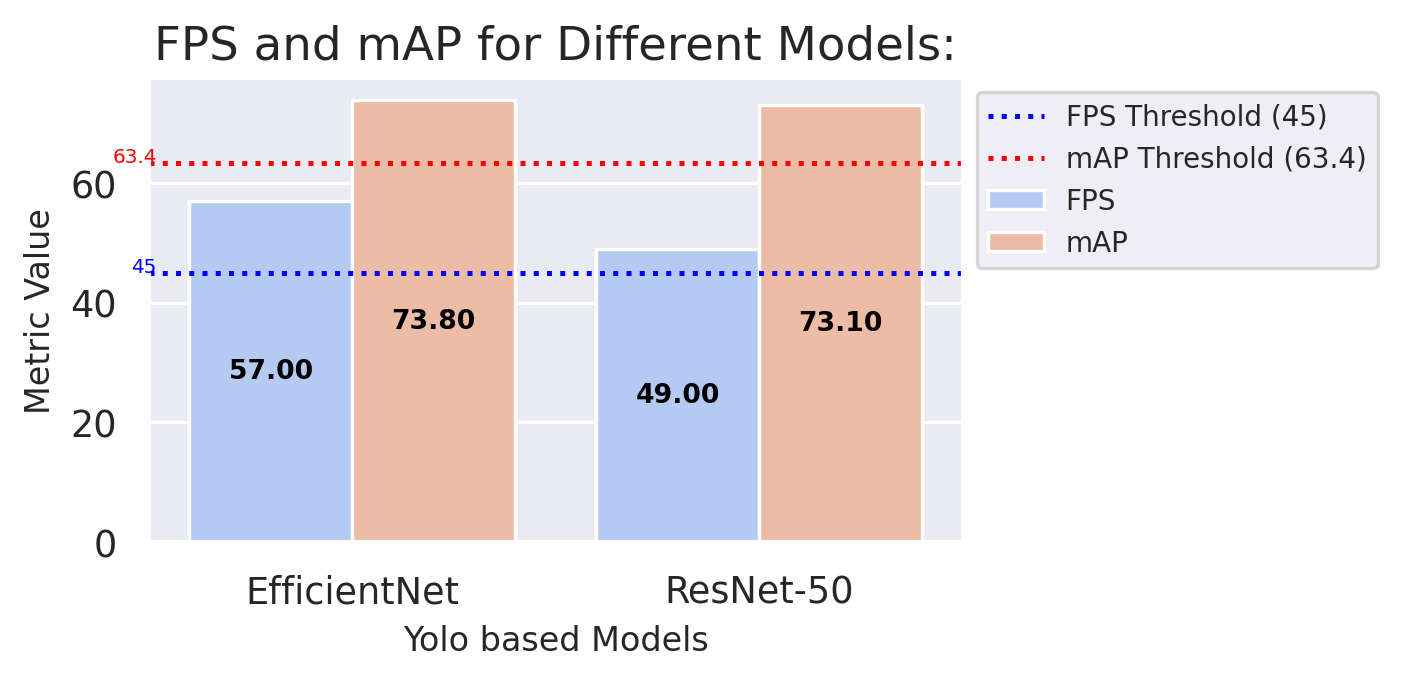

In [18]:
# Set the style
sns.set(style='darkgrid')

# Melt the dataframe
metrics_melted = pd.melt(metrics_df_comp,
                         id_vars='Yolo based Models',
                         value_vars=['FPS', 'mAP'],
                         var_name='Metric',
                         value_name='Value')

# Create the bar plot using Seaborn
plt.figure(figsize=(6, 3))

ax = sns.barplot(x='Yolo based Models',
                 y='Value',
                 hue='Metric',
                 data=metrics_melted,
                 palette='coolwarm')

# Add dotted lines for the threshold values
plt.axhline(y=45,
            linestyle='dotted',
            color='blue',
            label='FPS Threshold (45)')

plt.axhline(y=63.4,
            linestyle='dotted',
            color='red',
            label='mAP Threshold (63.4)')

# Set the labels for the x-axis
plt.xlabel('Yolo based Models', fontsize=10)

# Set the labels for the y-axis
plt.ylabel('Metric Value', fontsize=10)

# Set the title for the plot
plt.title('FPS and mAP for Different Models:',
          fontsize=14)

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left',
           fontsize='x-small')

# Add annotations to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2, height/2+0.02),
                ha='center',
                va='center',
                fontsize=8,
                fontweight='bold',
                color='black')

# Add text annotations for the threshold values on the y-axis
plt.text(-0.48, 63.4, '63.4', fontsize=6, color='red', ha='right')
plt.text(-0.48, 45, '45', fontsize=6, color='blue', ha='right')

# Show the plot
plt.tight_layout()
plt.show()

* We can say EfficientNet is the best model with good mAP and FPS